In [1]:
import lmdb
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.controller.trainer import MultiOutputClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.classification_3d.models.pointnet import PointNet, PointNetLoss
from torchlake.classification_3d.datasets.modelnet_40 import ModelNet40, MODELNET40_CLASS_NAMES, ModelNet40FromLMDB

# Setting

In [2]:
BATCH_SIZE = 64

In [3]:
artifact_path = Path("../../artifacts/pointnet")
artifact_path.mkdir(exist_ok=True)

data_path = Path("F://data/ModelNet40")

In [4]:
DEVICE = torch.device("cuda:0")

In [5]:
NUM_CLASS = len(MODELNET40_CLASS_NAMES)

# data

show mesh version for easier understanding of dataset

In [6]:
train_dataset = ModelNet40(
    data_path.as_posix(),
    mode="train",
    output_type="mesh",
    download=False,
    backend="trimesh",
)

# trimesh
train_dataset[4000][0].show() 

# open3d
# from torchlake.classification_3d.utils.plot import plot_mesh
# plot_mesh(train_dataset[4000][0])

In [7]:
from scipy.spatial.transform import Rotation
import numpy as np

def sphere_normalization(data:np.ndarray) -> np.ndarray:
    # https://github.com/charlesq34/pointnet/blob/2618f72bc1a0fd21b074096e748016960d44ef55/utils/pc_util.py#L116C1-L119C36
    centroid = np.mean(data, axis=0)
    data -= centroid
    furthest_distance = np.max(np.linalg.norm(data, ord=2, axis=-1))
    data /= furthest_distance
    
    return data

def gaussian_jitter(data:np.ndarray, sigma:float=0.01, clip:float=0.05) -> np.ndarray:
    # https://github.com/charlesq34/pointnet/blob/2618f72bc1a0fd21b074096e748016960d44ef55/provider.py#L74
    noise = np.random.Generator.normal(0, sigma, data.shape)
    noise = noise.clip(-clip, clip)
    
    return data + noise

def rotate_point_cloud(data:np.ndarray) -> np.ndarray:
    angles = np.random.uniform(0, 2 * np.pi)
    rot = Rotation.from_euler('z', angles)
    
    return rot.apply(data)

def preprocess(data:np.ndarray, aug: bool = False) -> np.ndarray: 
    data = sphere_normalization(data)
    
    if aug:
        data = rotate_point_cloud(data)
        # data = gaussian_jitter(data)
        
    # it is double for trimesh and scipy
    data = data.astype(np.float32)

    return data

use normalized and dense sampled point clouds for LMDB cache

In [8]:
# train_dataset = ModelNet40(
#     data_path.as_posix(),
#     mode="train",
#     output_type="pointcloud",
#     transform=preprocess,
#     num_points=1<<14,
#     download=False,
#     backend="trimesh",
# )

# env = lmdb.Environment(
#     data_path.joinpath("lmdb2").as_posix(),
#     map_size=1<<31,
# )
# train_dataset.to_lmdb(env)

In [9]:
# env.close()

In [10]:
train_dataset = ModelNet40FromLMDB(
    data_path.joinpath("lmdb-train").as_posix(),
    transform=lambda x: preprocess(x, aug=False), # aug not help
    num_points=1<<10,
)

In [11]:
len(train_dataset)

9843

Text(0.5, 0.92, 'airplane')

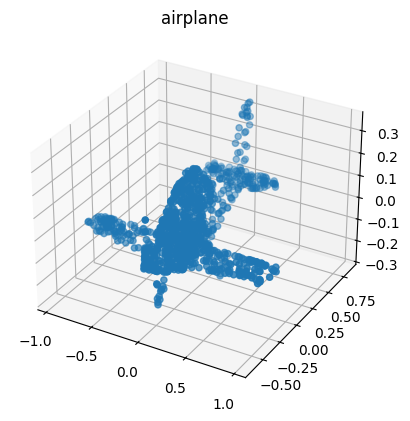

In [12]:
x, y= train_dataset[4000]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*x.T)

plt.title(MODELNET40_CLASS_NAMES[y])

In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [14]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 1024, 3]) torch.Size([64])


# model

In [15]:
model = PointNet(output_size=NUM_CLASS).to(DEVICE)

In [16]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
PointNet                                           --
├─ModuleDict: 1-1                                  --
│    └─TransformModule: 2-1                        --
│    │    └─TNet: 3-1                              801,097
│    └─Sequential: 2-2                             --
│    │    └─ConvBnRelu: 3-2                        320
│    │    └─ConvBnRelu: 3-3                        4,224
├─ModuleDict: 1-2                                  --
│    └─TransformModule: 2-3                        --
│    │    └─TNet: 3-4                              1,855,360
│    └─Sequential: 2-4                             --
│    │    └─ConvBnRelu: 3-5                        4,224
│    │    └─ConvBnRelu: 3-6                        8,448
│    │    └─ConvBnRelu: 3-7                        133,120
├─Sequential: 1-3                                  --
│    └─AdaptiveMaxPool1d: 2-5                      --
│    └─ConvBnRelu: 2-6                            

# training

In [17]:
EPOCH = 30

In [18]:
trainer = MultiOutputClassificationTrainer(EPOCH, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [19]:
criterion = PointNetLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

In [20]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=10, T_mult=2)

In [21]:
scaler = torch.amp.GradScaler()

In [22]:
training_loss = trainer.run(
    train_loader,
    model,
    optim,
    criterion,
    scheduler=scheduler,
    scaler=scaler,
)

Enable AMP: True
Training...


100%|██████████| 153/153 [00:13<00:00, 11.53it/s]


------------------------------------
Epoch 1
------------------------------------
total: 4.6353e-02 (0.00%)


100%|██████████| 153/153 [00:16<00:00,  9.38it/s]


------------------------------------
Epoch 2
------------------------------------
total: 3.3366e-02 (-28.00%)


100%|██████████| 153/153 [00:18<00:00,  8.40it/s]


------------------------------------
Epoch 3
------------------------------------
total: 2.8026e-02 (-16.00%)


100%|██████████| 153/153 [00:16<00:00,  9.00it/s]


------------------------------------
Epoch 4
------------------------------------
total: 2.4424e-02 (-13.00%)


100%|██████████| 153/153 [00:11<00:00, 13.89it/s]


------------------------------------
Epoch 5
------------------------------------
total: 2.1007e-02 (-14.00%)


100%|██████████| 153/153 [00:10<00:00, 14.51it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.8407e-02 (-12.00%)


100%|██████████| 153/153 [00:10<00:00, 14.34it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.6359e-02 (-11.00%)


100%|██████████| 153/153 [00:10<00:00, 14.46it/s]


------------------------------------
Epoch 8
------------------------------------
total: 1.4646e-02 (-10.00%)


100%|██████████| 153/153 [00:11<00:00, 13.84it/s]


------------------------------------
Epoch 9
------------------------------------
total: 1.3219e-02 (-10.00%)


100%|██████████| 153/153 [00:14<00:00, 10.58it/s]


------------------------------------
Epoch 10
------------------------------------
total: 1.1969e-02 (-9.00%)


100%|██████████| 153/153 [00:17<00:00,  8.70it/s]


------------------------------------
Epoch 11
------------------------------------
total: 1.0917e-02 (-9.00%)


100%|██████████| 153/153 [00:17<00:00,  8.65it/s]


------------------------------------
Epoch 12
------------------------------------
total: 1.0195e-02 (-7.00%)


100%|██████████| 153/153 [00:17<00:00,  8.68it/s]


------------------------------------
Epoch 13
------------------------------------
total: 9.3082e-03 (-9.00%)


100%|██████████| 153/153 [00:17<00:00,  8.75it/s]


------------------------------------
Epoch 14
------------------------------------
total: 8.7336e-03 (-6.00%)


100%|██████████| 153/153 [00:18<00:00,  8.48it/s]


------------------------------------
Epoch 15
------------------------------------
total: 8.1650e-03 (-7.00%)


100%|██████████| 153/153 [00:17<00:00,  8.67it/s]


------------------------------------
Epoch 16
------------------------------------
total: 7.7610e-03 (-5.00%)


100%|██████████| 153/153 [00:17<00:00,  8.72it/s]


------------------------------------
Epoch 17
------------------------------------
total: 7.2322e-03 (-7.00%)


100%|██████████| 153/153 [00:17<00:00,  8.84it/s]


------------------------------------
Epoch 18
------------------------------------
total: 6.9058e-03 (-5.00%)


100%|██████████| 153/153 [00:10<00:00, 13.98it/s]


------------------------------------
Epoch 19
------------------------------------
total: 6.4838e-03 (-6.00%)


100%|██████████| 153/153 [00:10<00:00, 14.50it/s]


------------------------------------
Epoch 20
------------------------------------
total: 6.3190e-03 (-3.00%)


100%|██████████| 153/153 [00:10<00:00, 14.58it/s]


------------------------------------
Epoch 21
------------------------------------
total: 5.9507e-03 (-6.00%)


100%|██████████| 153/153 [00:10<00:00, 14.51it/s]


------------------------------------
Epoch 22
------------------------------------
total: 5.6875e-03 (-4.00%)


100%|██████████| 153/153 [00:10<00:00, 14.72it/s]


------------------------------------
Epoch 23
------------------------------------
total: 5.5777e-03 (-2.00%)


100%|██████████| 153/153 [00:10<00:00, 14.65it/s]


------------------------------------
Epoch 24
------------------------------------
total: 5.4101e-03 (-3.00%)


100%|██████████| 153/153 [00:10<00:00, 14.73it/s]


------------------------------------
Epoch 25
------------------------------------
total: 5.1824e-03 (-4.00%)


100%|██████████| 153/153 [00:10<00:00, 14.65it/s]


------------------------------------
Epoch 26
------------------------------------
total: 5.0352e-03 (-3.00%)


100%|██████████| 153/153 [00:10<00:00, 14.72it/s]


------------------------------------
Epoch 27
------------------------------------
total: 4.7469e-03 (-6.00%)


100%|██████████| 153/153 [00:10<00:00, 14.68it/s]


------------------------------------
Epoch 28
------------------------------------
total: 4.7292e-03 (0.00%)


100%|██████████| 153/153 [00:10<00:00, 14.69it/s]


------------------------------------
Epoch 29
------------------------------------
total: 4.5060e-03 (-5.00%)


100%|██████████| 153/153 [00:10<00:00, 14.28it/s]

------------------------------------
Epoch 30
------------------------------------
total: 4.5386e-03 (1.00%)


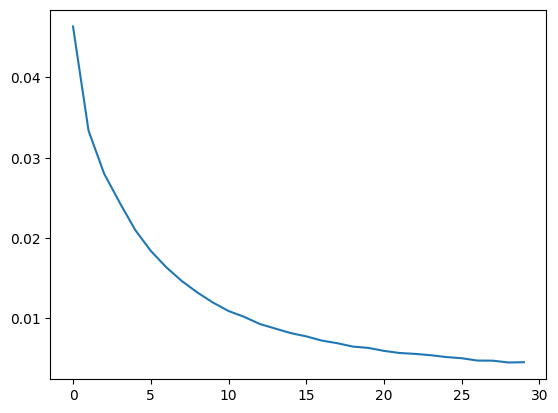

In [23]:
plt.plot(training_loss)

In [24]:
train_dataset.env.close()

# inference

In [25]:
# test_dataset = ModelNet40(
#     data_path.as_posix(),
#     mode="test",
#     output_type="pointcloud",
#     transform=preprocess,
#     num_points=1<<14,
#     download=False,
#     backend="trimesh",
# )

In [26]:
# env = lmdb.Environment(
#     data_path.joinpath("lmdb-test").as_posix(),
#     map_size=1<<31,
# )
# test_dataset.to_lmdb(env)

In [27]:
# env.close()

In [28]:
test_dataset = ModelNet40FromLMDB(
    data_path.joinpath("lmdb-test").as_posix(),
    transform=preprocess,
    num_points=1<<10,
)

In [29]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [30]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [31]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 39/39 [00:02<00:00, 16.64it/s]

[[97  0  0 ...  0  0  0]
 [ 0 44  2 ...  0  0  0]
 [ 0  0 99 ...  0  0  0]
 ...
 [ 0  0  0 ... 67  0  0]
 [ 0  0  0 ...  0  9  1]
 [ 0  0  0 ...  0  3 13]]


In [32]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(NUM_CLASS), per_class_acc)

0         : 0.97
1         : 0.88
2         : 0.99
3         : 0.75
4         : 0.91
5         : 0.96
6         : 1.0
7         : 0.97
8         : 0.99
9         : 0.9
10        : 0.85
11        : 0.7
12        : 0.8953488372093024
13        : 0.85
14        : 0.8372093023255814
15        : 0.0
16        : 0.82
17        : 0.96
18        : 0.95
19        : 0.9
20        : 1.0
21        : 0.92
22        : 0.93
23        : 0.7441860465116279
24        : 0.7
25        : 0.87
26        : 0.65
27        : 0.4
28        : 0.92
29        : 0.6
30        : 0.95
31        : 0.7
32        : 0.7
33        : 0.74
34        : 0.9
35        : 0.87
36        : 0.77
37        : 0.67
38        : 0.45
39        : 0.65


In [33]:
per_class_acc.mean()

np.float64(0.8054186046511628)

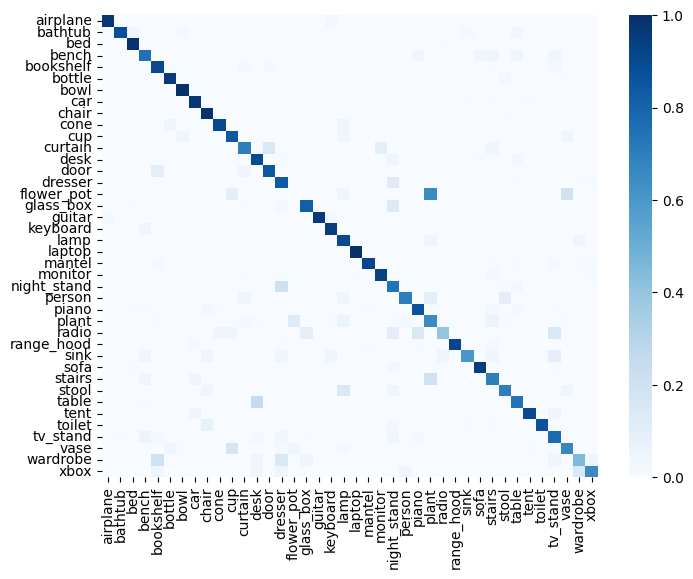

In [34]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    MODELNET40_CLASS_NAMES,
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [35]:
test_dataset.env.close()

In [36]:
model_path = artifact_path / f'pointnet.pth'

In [37]:
torch.save(model.state_dict(), model_path)

In [38]:
get_file_size(model_path)

'13.34MiB'

In [39]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>